In [1]:
# Function to generate wordclouds for each OEM
# Testing the change 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud, STOPWORDS



In [16]:
df = pd.read_csv("car_apps_reviews.csv")

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   app_name     15000 non-null  object
 1   review_text  15000 non-null  object
 2   review_date  15000 non-null  object
 3   rating       15000 non-null  int64 
 4   app_version  14107 non-null  object
 5   thumbs_up    15000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 703.2+ KB


In [23]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordclouds_by_oem(df, text_col, oem_col):
    """
    Generate and display larger wordclouds for each OEM in the dataset, removing stopwords and custom keywords.
    Args:
        df (pd.DataFrame): DataFrame containing reviews and OEM info
        text_col (str): Name of the column with review text
        oem_col (str): Name of the column with OEM info
    """
    # Add custom stopwords
    custom_stopwords = set(STOPWORDS).union({'app', 'car', 'work', 'vehicle','Ford'})
    oems = df[oem_col].unique()
    for oem in oems:
        text = " ".join(df[df[oem_col] == oem][text_col].astype(str))
        wc = WordCloud(width=1200, height=600, background_color='white', stopwords=custom_stopwords).generate(text)
        plt.figure(figsize=(12, 6))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"WordCloud for {oem}", fontsize=22)
        plt.show()

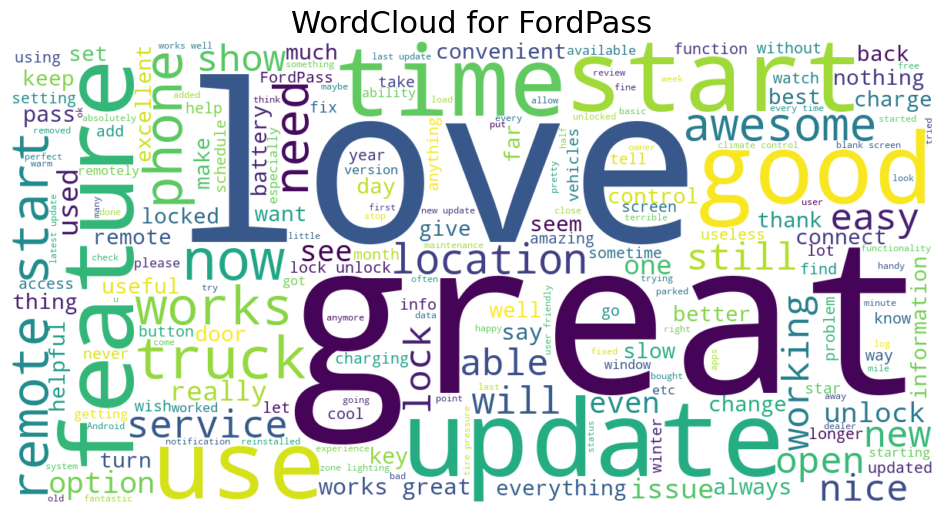

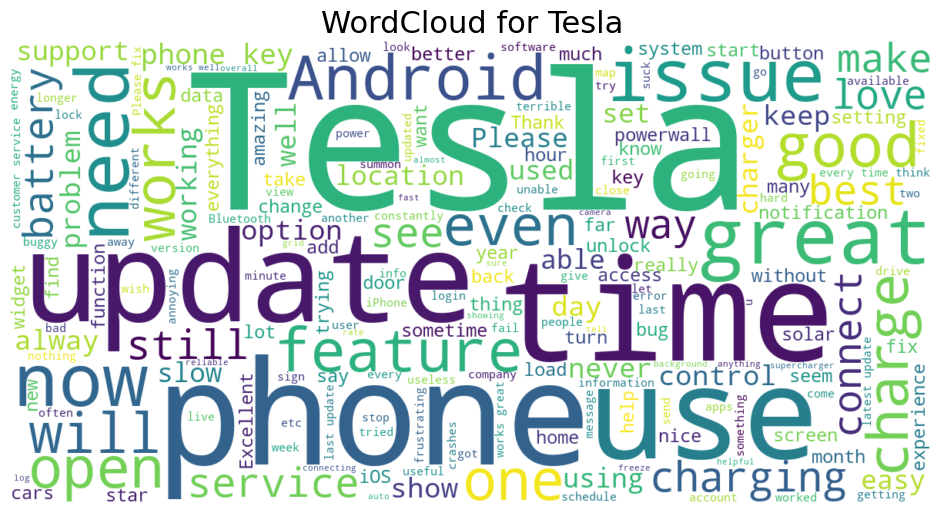

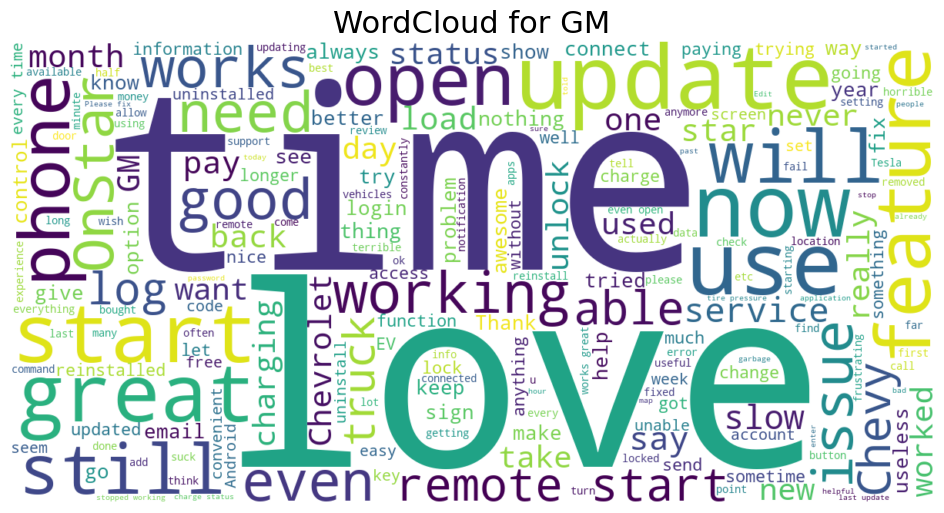

In [24]:
plot_wordclouds_by_oem(df,'review_text','app_name')

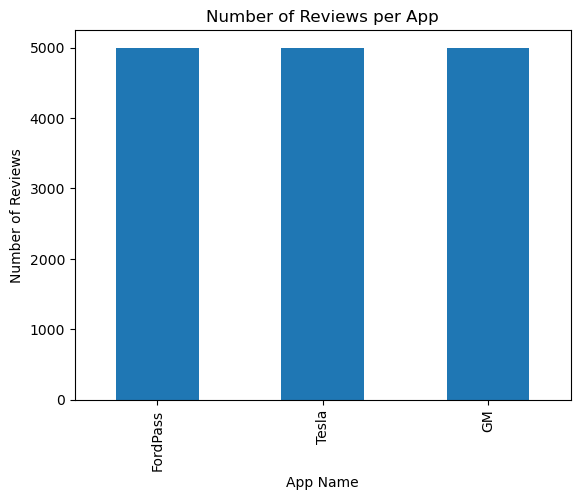

In [5]:
df['app_name'].value_counts().plot(kind='bar',xlabel='App Name', ylabel='Number of Reviews', title='Number of Reviews per App')
plt.show()

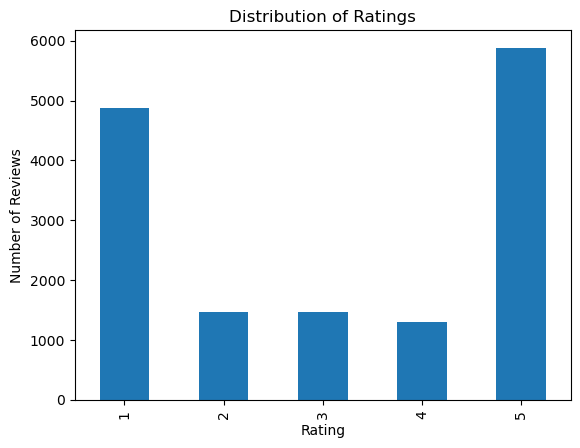

In [6]:
df['rating'].value_counts().sort_index().plot(kind='bar',xlabel='Rating', ylabel='Number of Reviews', title='Distribution of Ratings')
plt.show()

/var/folders/ys/rh_m_lvd12bc1py05dbf4g5m0000gn/T/ipykernel_16900/164534812.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.dropna(subset=['review_date']).groupby([pd.Grouper(key='review_date', freq='M'), 'app_name'])['rating'].mean().reset_index()


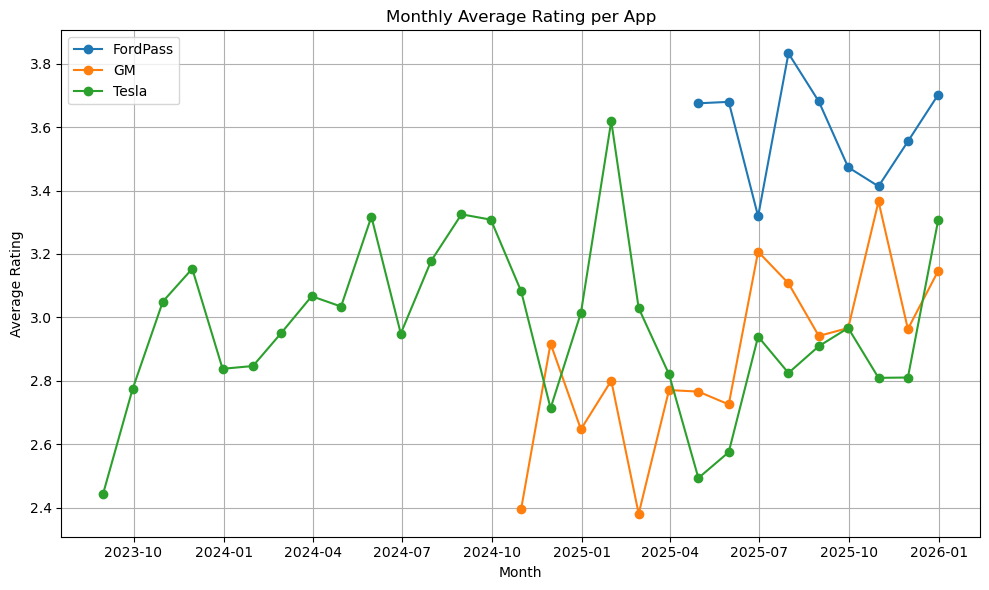

In [7]:
# Monthly average rating per app (line plot)
df['review_date'] = pd.to_datetime(df.get('review_date', df.get('at')), errors='coerce')
monthly = df.dropna(subset=['review_date']).groupby([pd.Grouper(key='review_date', freq='M'), 'app_name'])['rating'].mean().reset_index()
pivot = monthly.pivot(index='review_date', columns='app_name', values='rating')
plt.figure(figsize=(10,6))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker='o', label=col)
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.title('Monthly Average Rating per App')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()